# Agent testing (for bandits)

In [1]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.exp import epsilon_bandit
from infomercial.exp import beta_bandit
from infomercial.exp import softbeta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint

import gym

# --------------------------------------------------------------------------------
# Shared plots
def plot_critic(critic_name, env_name, result):
    # -
    env = gym.make(env_name)
    best = env.best
    
    # Data
    critic = result[critic_name]
    arms = list(critic.keys())
    values = list(critic.values())

    # Plotz
    fig = plt.figure(figsize=(8, 3))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0])
    plt.scatter(arms, values, color="black", alpha=.5, s=30)
    plt.plot([best]*10, np.linspace(min(values), max(values), 10), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Arm")

# Choose a bandit 

In [3]:
env_name = 'DeceptiveBanditOneHigh10-v0'
env_name = 'BanditOneHigh10-v0'

# Meta (dual value)

In [4]:
def plot_meta(env_name, result, tie_threshold):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, np.log(values_E), color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, np.log(values_R), color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="$\pi_{tie}$ : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Best arm: [7], last arm: 7


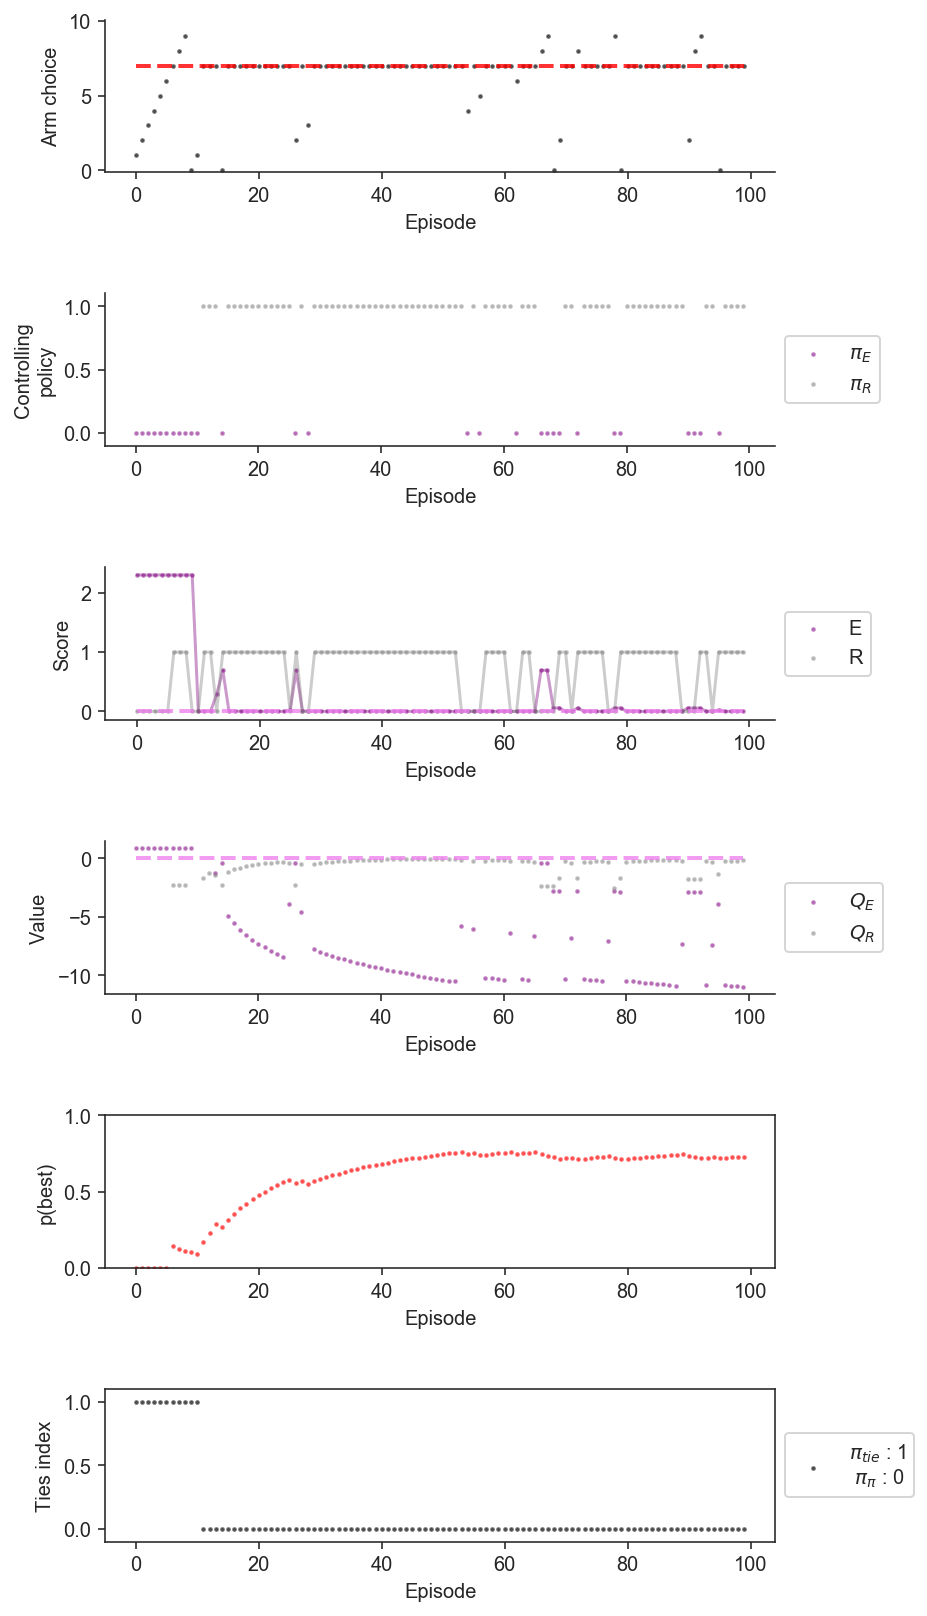

In [5]:
tie_threshold = 1e-4
result = meta_bandit(
    env_name=env_name,
    num_episodes=100, 
    lr_R=0.1,
    tie_threshold=tie_threshold,
    seed_value=None,
)

plot_meta(env_name, result, tie_threshold)

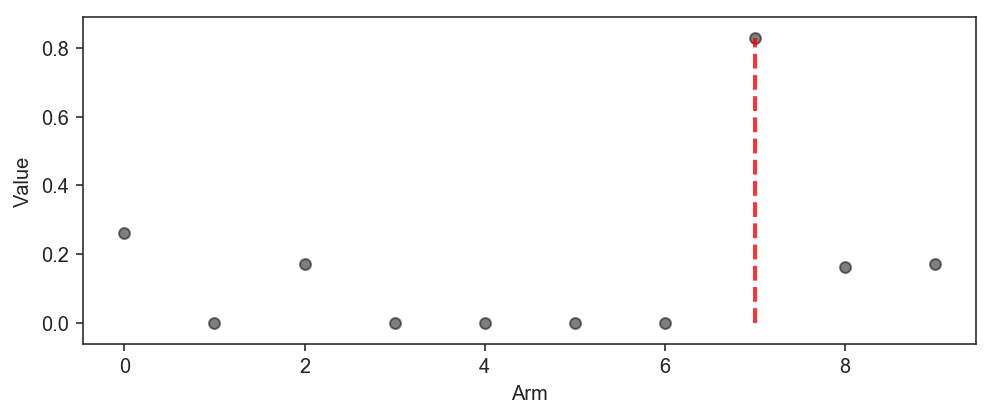

In [6]:
plot_critic('critic_R', env_name, result)

# Softbeta

In [7]:
def plot_beta(env_name, result):
    """Plots!"""
    
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]

    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

Best arm: [7], last arm: 2


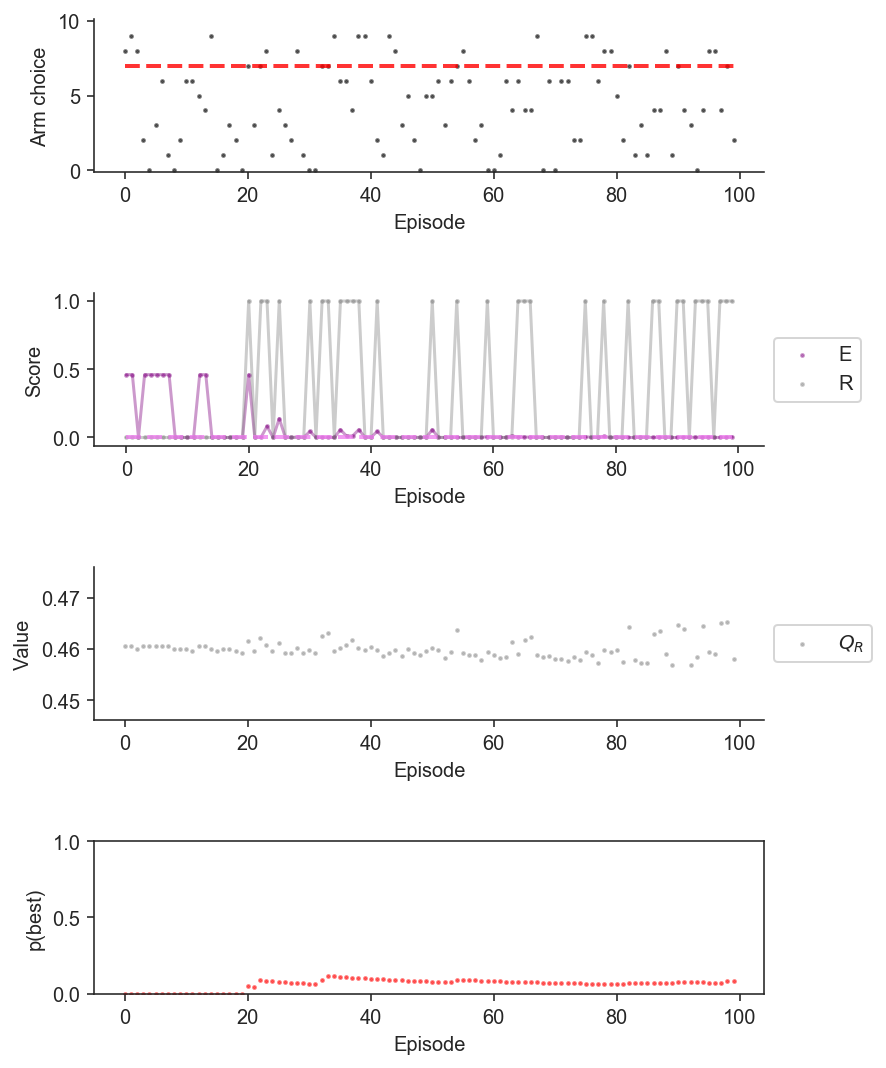

In [18]:
result = softbeta_bandit(
    env_name=env_name,
    num_episodes=100, 
    lr_R=0.001,
    beta=.2,
    seed_value=None,
)

plot_beta(env_name, result)

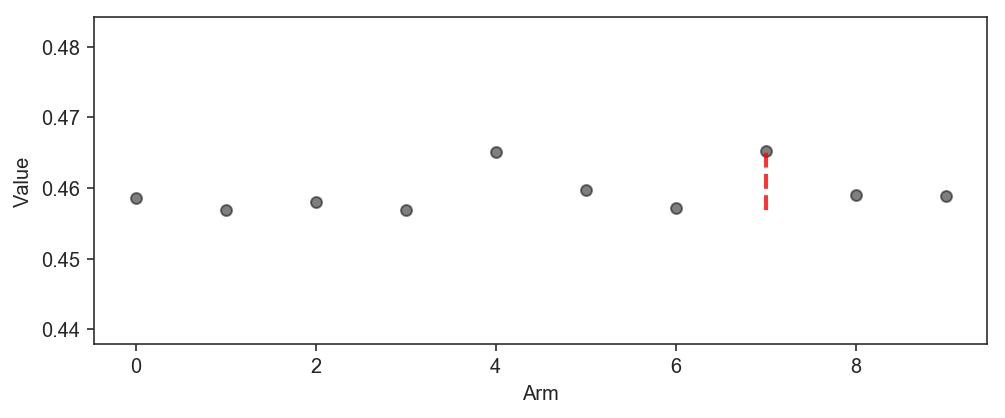

In [19]:
plot_critic('critic', env_name, result)

In [20]:
result.keys()

dict_keys(['best', 'lr_R', 'beta', 'temp', 'episodes', 'actions', 'p_bests', 'regrets', 'critic', 'total_E', 'total_R', 'scores_E', 'scores_R', 'values_R'])

# Beta (determistic)

Best arm: [7], last arm: 7


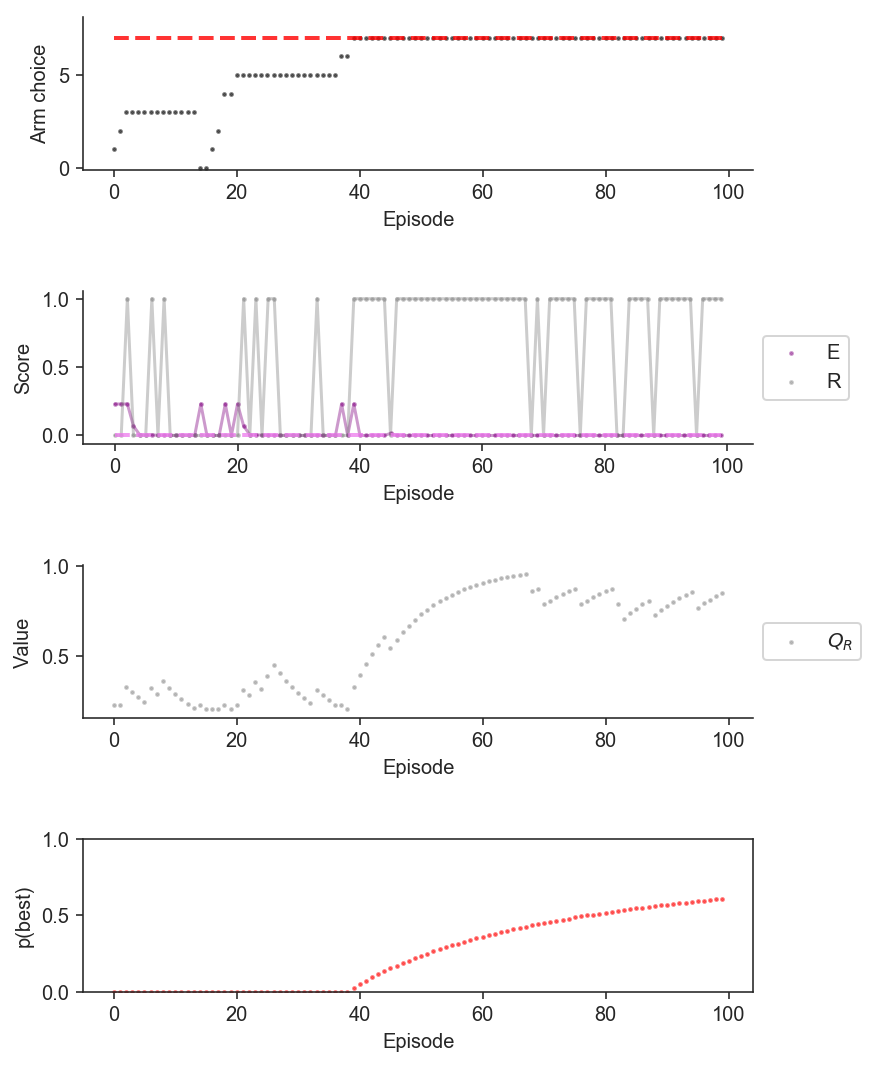

In [24]:
result = beta_bandit(
    env_name=env_name,
    num_episodes=100, 
    lr_R=0.1,
    beta=.1,
    seed_value=None,
)

plot_beta(env_name, result)

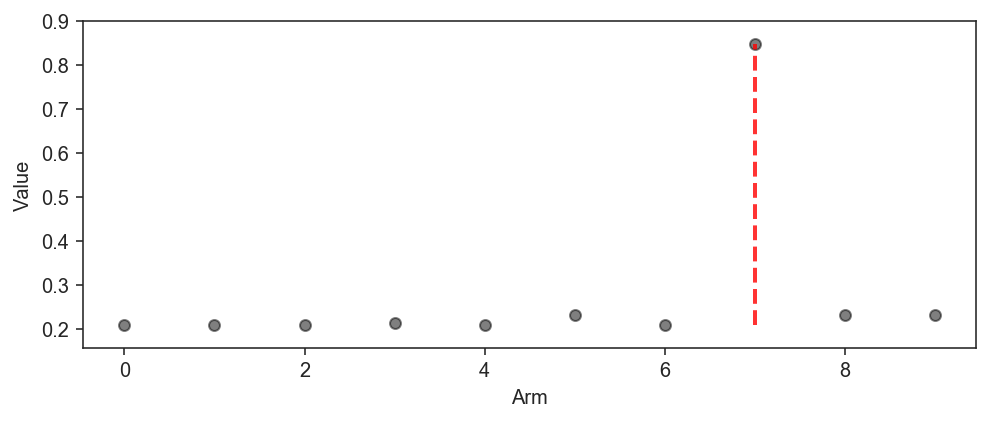

In [25]:
plot_critic('critic', env_name, result)

# Epsilon

In [26]:
def plot_epsilon(env_name, result):
    """Plots!"""
    
    episodes = result["episodes"]
    actions =result["actions"]
    bests = result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]

    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
    plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

Best arm: [7], last arm: 7


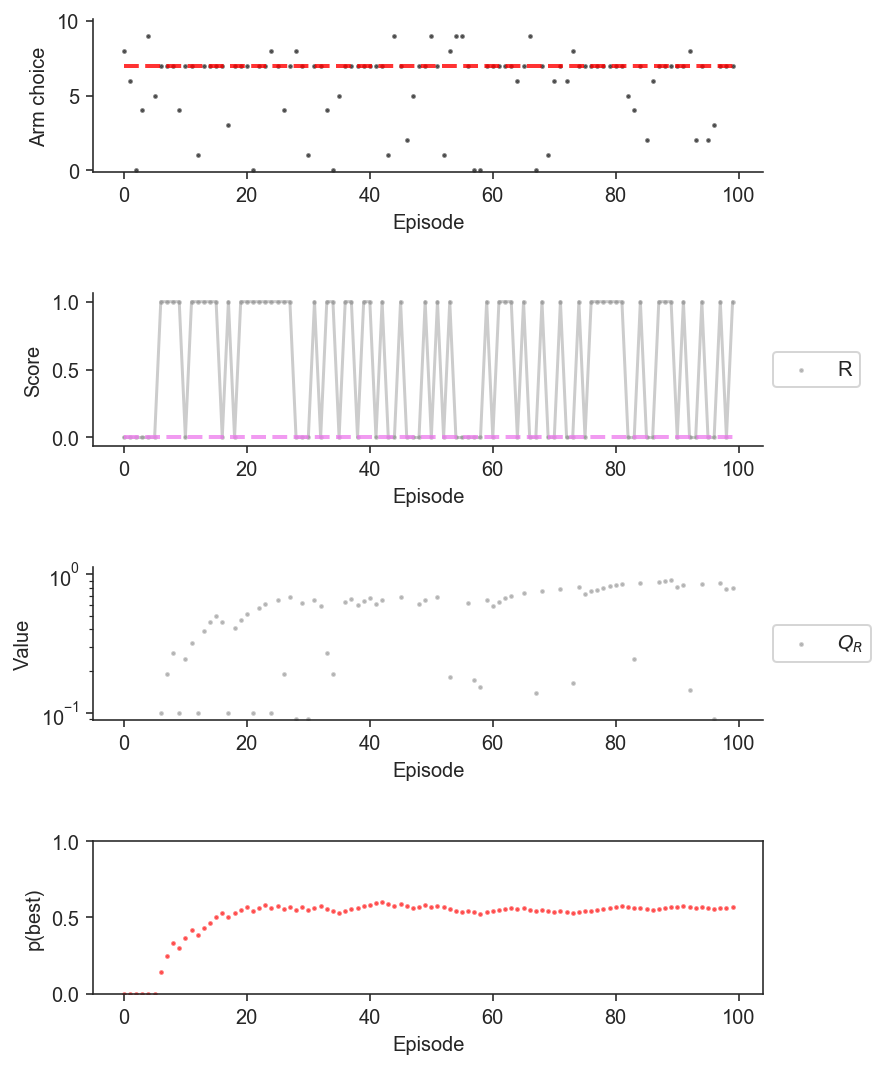

In [27]:
result = epsilon_bandit(
    env_name=env_name,
    num_episodes=100, 
    lr_R=0.1,
    epsilon=.5,
    epsilon_decay_tau=0.0000,
    seed_value=None,
)

plot_epsilon(env_name, result)

In [28]:
result.keys()

dict_keys(['best', 'episodes', 'num_episodes', 'lr_R', 'actions', 'p_bests', 'regrets', 'epsilons', 'visited_states', 'critic_R', 'total_R', 'scores_R', 'values_R'])

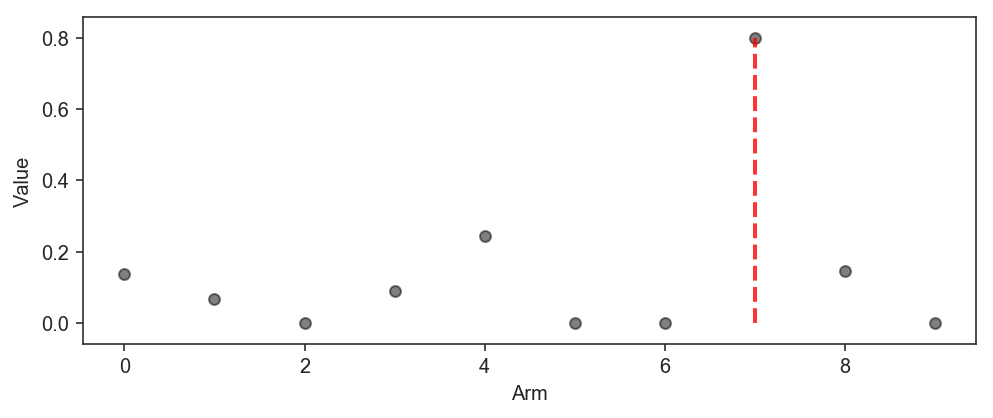

In [29]:
plot_critic('critic_R', env_name, result)